<a href="https://colab.research.google.com/github/NourKandil-24/Fire-Detection-with-AI/blob/main/Fire_Detection_Final_Draft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from skimage.feature import hog, local_binary_pattern
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import os
from sklearn.svm import SVC
import cv2
from PIL import Image
import pandas as pd
from google.colab import drive
from scipy.stats import kurtosis, skew
from scipy.fft import fft2

In [ ]:
#Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
fire_path = '/content/drive/MyDrive/Final data/Dataset/Fire'
no_fire_path = '/content/drive/MyDrive/Final data/Dataset/Nofire'


In [ ]:
# load data
def load_images_from_folder(folder, label, image_size=(64, 64)):
    images = []
    labels = []
    for root, dirs, files in os.walk(folder):
        for filename in files:  # Only process files
            file_path = os.path.join(root, filename)
            try:
                img = Image.open(file_path).convert("L") # Remove .convert('L') to keep original color
                img = img.resize(image_size)  # Resize to the specified size
                img = np.array(img) / 255.0  # Normalize pixel values
                images.append(img)
                labels.append(label)
            except Exception as e:
                print(f"Error loading {file_path}: {e}")
    return np.array(images), np.array(labels)

fire_images, fire_labels = load_images_from_folder(fire_path, label=1)
no_fire_images, no_fire_labels = load_images_from_folder(no_fire_path, label=0)
images = np.concatenate((fire_images, no_fire_images), axis=0)
labels = np.concatenate((fire_labels, no_fire_labels), axis=0)
#used to combine two arrays, fire_images and no_fire_images, along a specified axis.

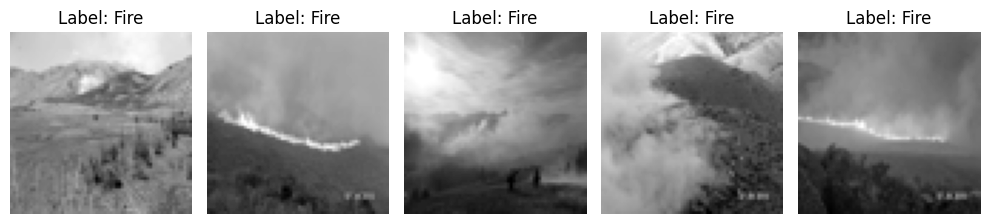

In [ ]:
#load 5 random images
fig, axes = plt.subplots(1, 5, figsize=(10, 5))  # Adjust number of subplots if needed
for i, ax in enumerate(axes):
    if i < len(images):  # Ensure index is within bounds
        ax.imshow(images[i], cmap='gray')
        ax.set_title(f"Label: {'No Fire' if labels[i] == 0 else 'Fire'}")
        ax.axis('off')
    else:
        ax.axis('off')  # Turn off axes for empty plots

plt.tight_layout()
plt.show()

In [ ]:
# Split dataset into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
#training 70% val:15%, test:15%
print("Fire shape:",fire_images.shape)
print("Fire labels shape:", fire_labels.shape)
print("No Fire images shape:", no_fire_images.shape)
print("Tulip labels shape:", no_fire_labels.shape)
print("All images shape:", images.shape)
print("All labels shape:", labels.shape)

Fire shape: (150, 64, 64)
Fire labels shape: (150,)
No Fire images shape: (150, 64, 64)
Tulip labels shape: (150,)
All images shape: (300, 64, 64)
All labels shape: (300,)


In [ ]:
# Feature extraction functions

# HOG function
def extract_hog_features(images):
    hog_features = []
    for img in images:
        if len(img.shape) == 3:  # Convert RGB to grayscale
            img = np.mean(img, axis=-1)
        features, _ = hog(img, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
        hog_features.append(features)
    return np.array(hog_features)

# Function to extract LBP features
def extract_lbp_features(images, P=8, R=1):
    lbp_features = []
    for img in images:
        lbp = local_binary_pattern(img, P=P, R=R, method='uniform')
        lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, P + 3), range=(0, P + 2))
        lbp_hist = lbp_hist.astype("float")
        lbp_hist /= (lbp_hist.sum() + 1e-7)  # Normalize histogram
        lbp_features.append(lbp_hist)
    return np.array(lbp_features)

def extract_hsv_features(images, hist_bins=(8, 8, 8)):
    hsv_features = []
    for img in images:
        # Convert image to HSV color space
        hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

        # Compute histograms for H, S, and V channels
        hist_h = cv2.calcHist([hsv_img], [0], None, [hist_bins[0]], [0, 180])  # Hue channel
        hist_s = cv2.calcHist([hsv_img], [1], None, [hist_bins[1]], [0, 256])  # Saturation channel
        hist_v = cv2.calcHist([hsv_img], [2], None, [hist_bins[2]], [0, 256])  # Value channel

        # Normalize histograms
        hist_h = cv2.normalize(hist_h, hist_h).flatten()
        hist_s = cv2.normalize(hist_s, hist_s).flatten()
        hist_v = cv2.normalize(hist_v, hist_v).flatten()

        # Concatenate H, S, and V histograms into a single feature vector
        hsv_hist = np.concatenate((hist_h, hist_s, hist_v))
        hsv_features.append(hsv_hist)

    return np.array(hsv_features)

# Extract HOG features for datasets
X_train_hog = extract_hog_features(X_train)
X_val_hog = extract_hog_features(X_val)
X_test_hog = extract_hog_features(X_test)


# Extract LBP features for the dataset
lbp_train = extract_lbp_features(X_train)
lbp_val = extract_lbp_features(X_val)
lbp_test = extract_lbp_features(X_test)

# Extract HSV features for the dataset
hsv_train = extract_lbp_features(X_train)
hsv_val = extract_lbp_features(X_val)
hsv_test = extract_lbp_features(X_test)

# Combine all features
X_train_combined = np.hstack([X_train_hog, lbp_train,hsv_train])
X_val_combined = np.hstack([X_val_hog, lbp_val,hsv_val])
X_test_combined = np.hstack([X_test_hog, lbp_test,hsv_test])

/usr/local/lib/python3.10/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


In [ ]:
# Normalize the features using MinMaxScaler
scaler = MinMaxScaler()
X_train_combined = scaler.fit_transform(X_train_combined)
X_val_combined = scaler.transform(X_val_combined)
X_test_combined = scaler.transform(X_test_combined)

In [ ]:
# Function to train and evaluate KNN, SVM, and Random Forest models for individual features
def evaluate_knn_svm_rf(X_train, X_val, X_test, y_train, y_val, y_test, feature_name):
    # Normalize the features using MinMaxScaler
    scaler = MinMaxScaler()
    X_train_norm = scaler.fit_transform(X_train)
    X_val_norm = scaler.transform(X_val)
    X_test_norm = scaler.transform(X_test)

    # Train KNN classifier
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train_norm, y_train)

    # Validate the KNN model
    y_val_pred_knn = knn.predict(X_val_norm)
    val_accuracy_knn = accuracy_score(y_val, y_val_pred_knn)
    print(f"{feature_name} - KNN Validation Accuracy: {val_accuracy_knn * 100:.2f}%")

    # Test the KNN model
    y_test_pred_knn = knn.predict(X_test_norm)
    test_accuracy_knn = accuracy_score(y_test, y_test_pred_knn)
    print(f"{feature_name} - KNN Test Accuracy: {test_accuracy_knn * 100:.2f}%")

    # Confusion matrix for KNN
    cm_knn = confusion_matrix(y_test, y_test_pred_knn)
    disp=ConfusionMatrixDisplay(cm_knn)
    disp.plot(cmap='Reds')
    plt.title(f"KNN Confusion Matrix for {feature_name}")
    plt.show()
    print('---------------------------------------------')
    print()

    # Train SVM classifier
    svm = SVC(kernel='linear')  # You can change the kernel if needed (e.g., 'rbf', 'poly')
    svm.fit(X_train_norm, y_train)

    # Validate the SVM model
    y_val_pred_svm = svm.predict(X_val_norm)
    val_accuracy_svm = accuracy_score(y_val, y_val_pred_svm)
    print(f"{feature_name} - SVM Validation Accuracy: {val_accuracy_svm * 100:.2f}%")

    # Test the SVM model
    y_test_pred_svm = svm.predict(X_test_norm)
    test_accuracy_svm = accuracy_score(y_test, y_test_pred_svm)
    print(f"{feature_name} - SVM Test Accuracy: {test_accuracy_svm * 100:.2f}%")

    # Confusion matrix for SVM
    cm_svm = confusion_matrix(y_test, y_test_pred_svm)
    disp1=ConfusionMatrixDisplay(cm_svm)
    disp1.plot(cmap='Blues')
    plt.title(f"SVM Confusion Matrix for {feature_name}")
    plt.show()
    print('---------------------------------------------')
    print()
    # Train Random Forest classifier
    rf = RandomForestClassifier(n_estimators=100, random_state=42)  # Random forest with 100 trees
    rf.fit(X_train_norm, y_train)

    # Validate the Random Forest model
    y_val_pred_rf = rf.predict(X_val_norm)
    val_accuracy_rf = accuracy_score(y_val, y_val_pred_rf)
    print(f"{feature_name} - Random Forest Validation Accuracy: {val_accuracy_rf * 100:.2f}%")

    # Test the Random Forest model
    y_test_pred_rf = rf.predict(X_test_norm)
    test_accuracy_rf = accuracy_score(y_test, y_test_pred_rf)
    print(f"{feature_name} - Random Forest Test Accuracy: {test_accuracy_rf * 100:.2f}%")

    # Confusion matrix for Random Forest
    cm_rf = confusion_matrix(y_test, y_test_pred_rf)
    disp2=ConfusionMatrixDisplay(cm_rf)
    disp2.plot(cmap='Greens')
    plt.title(f"Random Forest Confusion Matrix for {feature_name}")
    plt.show()



HOG Features - KNN Validation Accuracy: 55.56%
HOG Features - KNN Test Accuracy: 51.11%


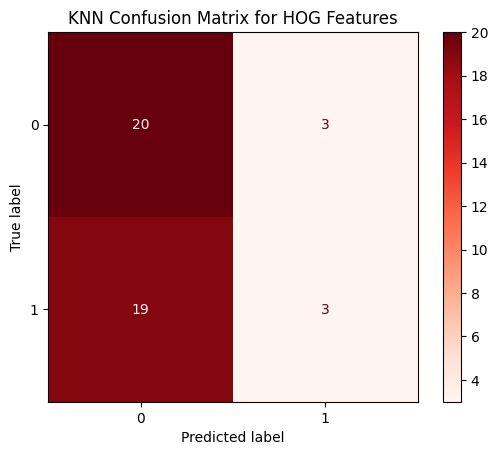

---------------------------------------------

HOG Features - SVM Validation Accuracy: 68.89%
HOG Features - SVM Test Accuracy: 66.67%


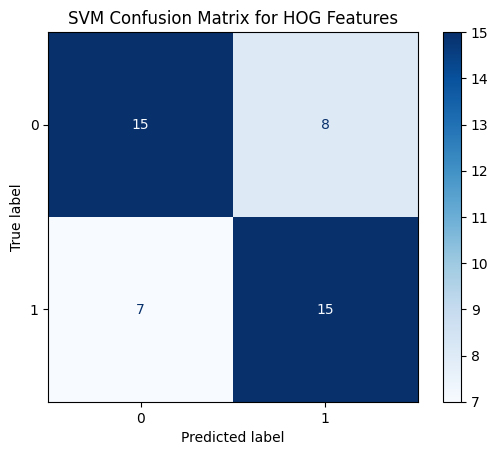

---------------------------------------------

HOG Features - Random Forest Validation Accuracy: 66.67%
HOG Features - Random Forest Test Accuracy: 73.33%


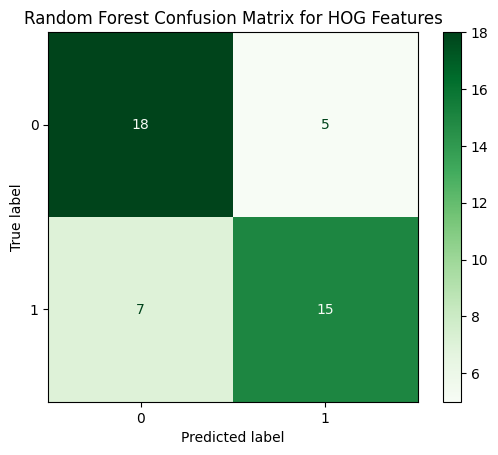

In [ ]:
# Evaluate HOG features with KNN, SVM, and Random Forest
evaluate_knn_svm_rf(X_train_hog, X_val_hog, X_test_hog, y_train, y_val, y_test, "HOG Features")

LBP FEATURES - KNN Validation Accuracy: 64.44%
LBP FEATURES - KNN Test Accuracy: 73.33%


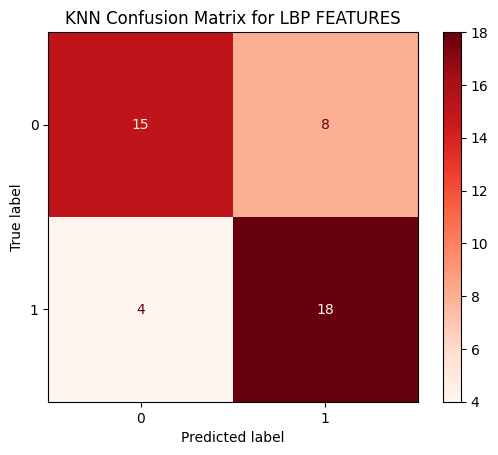

---------------------------------------------

LBP FEATURES - SVM Validation Accuracy: 73.33%
LBP FEATURES - SVM Test Accuracy: 66.67%


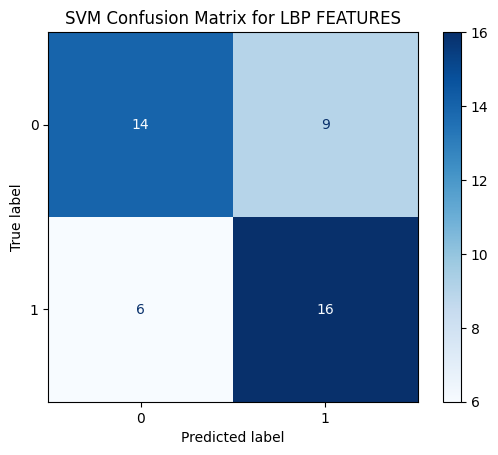

---------------------------------------------

LBP FEATURES - Random Forest Validation Accuracy: 71.11%
LBP FEATURES - Random Forest Test Accuracy: 73.33%


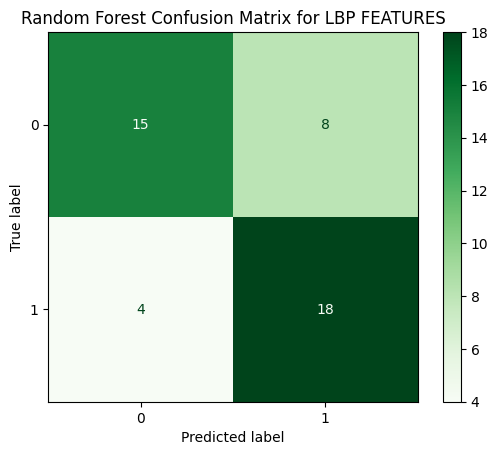

In [ ]:
# Evaluate LBP features with KNN, SVM, and Random Forest
evaluate_knn_svm_rf(lbp_train, lbp_val ,lbp_test, y_train, y_val, y_test, "LBP FEATURES")

HSV FEATURES - KNN Validation Accuracy: 64.44%
HSV FEATURES - KNN Test Accuracy: 73.33%


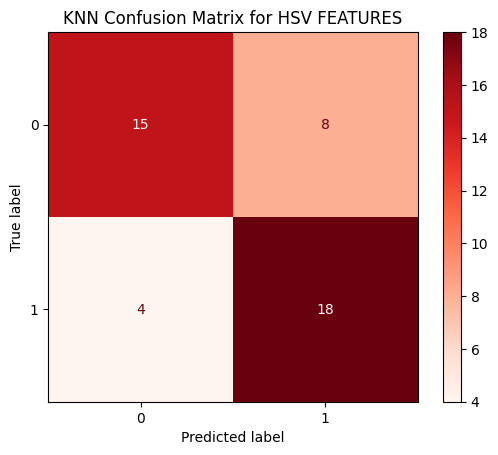

---------------------------------------------

HSV FEATURES - SVM Validation Accuracy: 73.33%
HSV FEATURES - SVM Test Accuracy: 66.67%


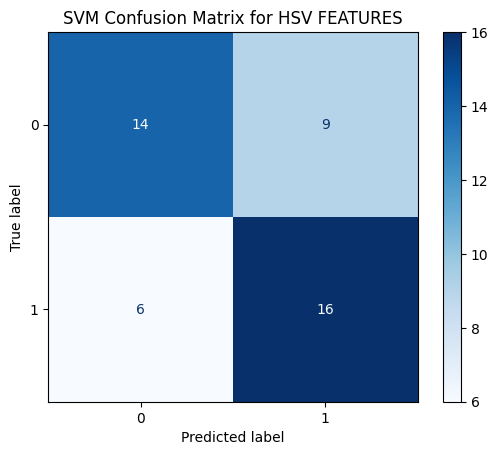

---------------------------------------------

HSV FEATURES - Random Forest Validation Accuracy: 71.11%
HSV FEATURES - Random Forest Test Accuracy: 73.33%


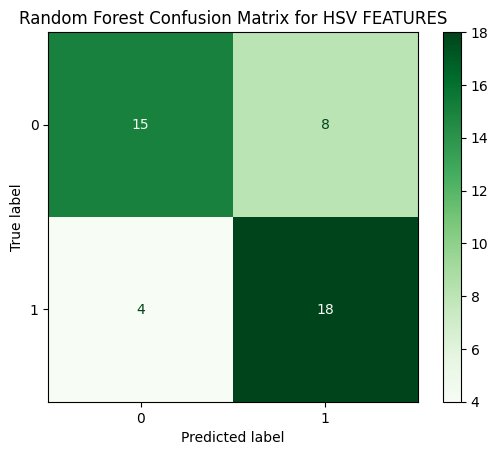

In [ ]:
# Evaluate HSV features with KNN, SVM, and Random Forest
evaluate_knn_svm_rf(hsv_train, hsv_val ,hsv_test, y_train, y_val, y_test, "HSV FEATURES")

In [ ]:
# Define classifiers , hypergrid parameters
classifiers = {
    'KNN': {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [3, 5, 7],
            'metric': ['euclidean', 'manhattan']
        }
    },
    'SVM': {
        'model': SVC(),
        'params': {
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'rbf']
        }
    },
    'RandomForest': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': [50, 100],
            'max_depth': [10, 20, None]
        }
    }
}



# Iterate through classifiers and perform GridSearchCV
results = []
best_estimator = {}
for name, clf in classifiers.items():
    print(f"Running GridSearchCV for {name}...")
    grid_search = GridSearchCV(estimator=clf['model'], param_grid=clf['params'], cv=5, scoring='accuracy')
    grid_search.fit(X_train_combined, y_train) #Fits (trains) the model using the training data (parameters) provided

    # Store results
    results.append({
        'Classifier': name,
        'Best Params': grid_search.best_params_,
        'Best CV Accuracy': grid_search.best_score_
    })
    best_estimator[name] = grid_search.best_estimator_
    print(f"{name} - Best Params: {grid_search.best_params_}, Best CV Accuracy: {grid_search.best_score_:.2f}")

# Display final results
print("\nSummary of Results:")
for result in results:
    print(result)

Running GridSearchCV for KNN...
KNN - Best Params: {'metric': 'manhattan', 'n_neighbors': 3}, Best CV Accuracy: 0.57
Running GridSearchCV for SVM...
SVM - Best Params: {'C': 10, 'kernel': 'rbf'}, Best CV Accuracy: 0.72
Running GridSearchCV for RandomForest...
RandomForest - Best Params: {'max_depth': 10, 'n_estimators': 100}, Best CV Accuracy: 0.77

Summary of Results:
{'Classifier': 'KNN', 'Best Params': {'metric': 'manhattan', 'n_neighbors': 3}, 'Best CV Accuracy': 0.5666666666666667}
{'Classifier': 'SVM', 'Best Params': {'C': 10, 'kernel': 'rbf'}, 'Best CV Accuracy': 0.719047619047619}
{'Classifier': 'RandomForest', 'Best Params': {'max_depth': 10, 'n_estimators': 100}, 'Best CV Accuracy': 0.7714285714285714}


SVM validation Accuracy: 71.11%
SVM test Accuracy: 77.78%


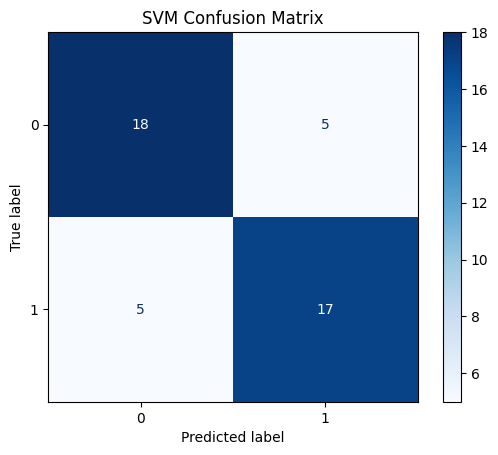

In [ ]:
# Train an SVM classifier using best parameters
svm = SVC(kernel='rbf', C=10.0, gamma='scale')
svm.fit(X_train_combined, y_train)

# Validate the model
y_val_pred = svm.predict(X_val_combined)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"SVM validation Accuracy: {val_accuracy * 100:.2f}%")

# Test the model
y_test_pred = svm.predict(X_test_combined)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"SVM test Accuracy: {test_accuracy * 100:.2f}%")

# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
disp=ConfusionMatrixDisplay(cm)
disp.plot(cmap='Blues')
plt.title("SVM Confusion Matrix")
plt.show()

Random Forest Validation Accuracy: 66.67%
Random Forest Test Accuracy: 80.00%


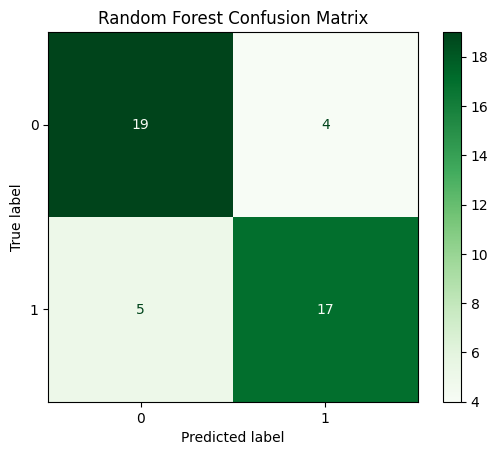

In [ ]:
# Train a Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_combined, y_train)

# Validate the model
y_val_pred = rf.predict(X_val_combined)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Random Forest Validation Accuracy: {val_accuracy * 100:.2f}%")

# Test the model
y_test_pred = rf.predict(X_test_combined)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Random Forest Test Accuracy: {test_accuracy * 100:.2f}%")

# Confusion matrix
confumat = confusion_matrix(y_test, y_test_pred)
disp=ConfusionMatrixDisplay(confumat)
disp.plot(cmap='Greens')
plt.title("Random Forest Confusion Matrix")
plt.show()

KNN validation Accuracy: 55.56%
KNN test Accuracy: 60.00%


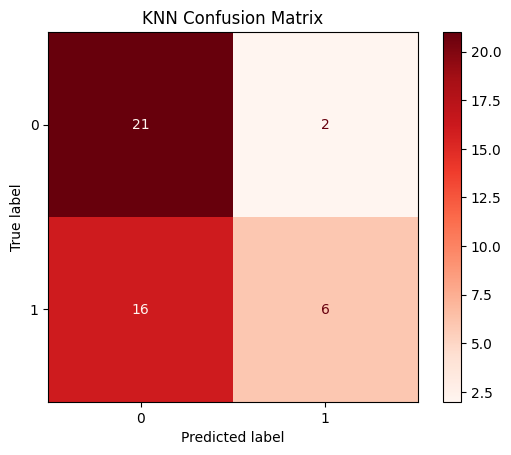

In [ ]:
 #Train a KNN classifier
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_combined, y_train)

# Validate the model
y_val_pred = knn.predict(X_val_combined)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"KNN validation Accuracy: {val_accuracy * 100:.2f}%")

# Test the model
y_test_pred = knn.predict(X_test_combined)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"KNN test Accuracy: {test_accuracy * 100:.2f}%")

# Confusion matrix
confmat = confusion_matrix(y_test, y_test_pred)
disp=ConfusionMatrixDisplay(confmat)
disp.plot(cmap='Reds')
plt.title("KNN Confusion Matrix")
plt.show()
#It is suggested that KNN struggles to make accurate predicitions on the dataset due to its complexity

Best Classifier: RandomForest
Test Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.87      0.83        23
           1       0.85      0.77      0.81        22

    accuracy                           0.82        45
   macro avg       0.82      0.82      0.82        45
weighted avg       0.82      0.82      0.82        45



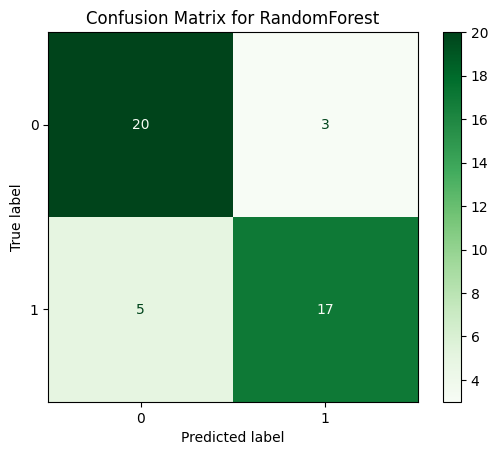

In [ ]:
#Evaluating Performance of best calssifier - random forest
# Select the best classifier based on CV accuracy
best_classifier_n = max(results, key=lambda x: x['Best CV Accuracy'])['Classifier']
best_classifier = best_estimator[best_classifier_n]
print(f"Best Classifier: {best_classifier_n}")

# Train and test the best classifier
best_classifier.fit(X_train_combined, y_train)
y_test_pred = best_classifier.predict(X_test_combined)

# Evaluate the best classifier
print("Test Classification Report:")
print(classification_report(y_test, y_test_pred))

# Generate confusion matrix
confm = confusion_matrix(y_test, y_test_pred)
disp=ConfusionMatrixDisplay(confm)
disp.plot(cmap='Greens')
plt.title(f"Confusion Matrix for {best_classifier_n}")
plt.show()

#Precision measures how many of the predicted positive labels are actually correct.
# Recall measures how many of the actual positives are correctly identified.
#The F1-Score is the harmonic mean of precision and recall, providing a balance between the two
#Support is the number of actual occurrences of each class in the dataset.


In [ ]:
import cv2
import numpy as np
from skimage.feature import hog, local_binary_pattern

def extract_brightness_feature(image):
    # Convert image to HSV
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # Get the brightness (V channel)
    brightness = hsv_image[:, :, 2]
    # Calculate the average brightness
    avg_brightness = np.mean(brightness)
    return avg_brightness

def extract_high_brightness_ratio(image, threshold=200):
    # Convert image to HSV
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # Get the brightness (V channel)
    brightness = hsv_image[:, :, 2]
    # Calculate the ratio of pixels above the threshold
    bright_regions = brightness > threshold
    bright_ratio = np.sum(bright_regions) / brightness.size
    return bright_ratio


def extract_lbp_features(image, P=8, R=1, is_gray=False): # Added is_gray parameter
    lbp_features = []
    # Convert image to grayscale only if not already grayscale
    if not is_gray:
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray_image = image
    # Resize image to 64x64 for consistency with training data
    resized_image = cv2.resize(gray_image, (64, 64))

    lbp = local_binary_pattern(resized_image, P=P, R=R, method='uniform')
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, P + 3), range=(0, P + 2))
    lbp_hist = lbp_hist.astype("float")
    lbp_hist /= (lbp_hist.sum() + 1e-7)  # Normalize histogram
    lbp_features.append(lbp_hist)
    return np.array(lbp_features)

def extract_hsv_features(image, hist_bins=(8, 8, 8)):  # Example implementation
    # Check if the image is grayscale and convert to BGR if necessary
    if len(image.shape) == 2:  # Grayscale image
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv_image], [0, 1, 2], None, hist_bins, [0, 180, 0, 256, 0, 256])
    hist = cv2.normalize(hist, hist).flatten()
    return hist

def predict_fire(image, model, scaler):
    # Feature extraction (same as in training)
    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    img_gray = cv2.resize(img_gray, (64, 64)) / 255.0  # Resize to match training data

    # Extract HOG, LBP, and HSV features (to match training data)
    hog_features = hog(img_gray, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=False, feature_vector=True)
    lbp_features = extract_lbp_features(img_gray, is_gray=True)[0]  # Ensure is_gray=True

    # Resize image for HSV feature extraction to match training data
    resized_image_hsv = cv2.resize(image, (64, 64))
    hsv_features = extract_hsv_features(resized_image_hsv)

    # Combine all features (to match training data)
    combined_features = np.hstack([hog_features, lbp_features, hsv_features])

    # Check if the number of features matches the scaler's expectation
    if combined_features.shape[0] != scaler.n_features_in_:
        print(f"Warning: Number of features in the input image ({combined_features.shape[0]}) does not match the number of features the scaler was trained on ({scaler.n_features_in_}).")
        print("This might lead to unexpected results. Please ensure feature extraction consistency.")
        # Resize the feature vector to match the expected size
        # This assumes the extra features are at the end. Adjust if necessary.
        combined_features = combined_features[:scaler.n_features_in_]  # Trim extra features
        # If the features are missing, you might need to pad with zeros or impute values:
        # combined_features = np.pad(combined_features, (0, scaler.n_features_in_ - combined_features.shape[0]), 'constant')

    # Normalize features
    features = scaler.transform(combined_features.reshape(1, -1))  # Reshape and normalize

    # Predict using the trained model
    prediction = model.predict(features)
    return "Fire" if prediction[0] == 1 else "No Fire"


# Test on a new image
test_image = cv2.imread("/content/drive/MyDrive/Final data/Dataset/Fire/27866316047_a4b6968d59_o.jpg")

# Check if the image was loaded successfully
if test_image is None:
    print("Error: Could not load image. Please check the file path.")
else:
    result = predict_fire(test_image, rf, scaler) # Pass the scaler used during training
    print(f"Prediction: {result}")

This might lead to unexpected results. Please ensure feature extraction consistency.
Prediction: Fire


/usr/local/lib/python3.10/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


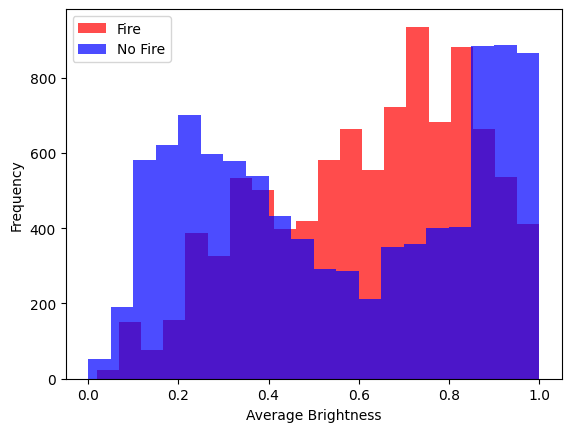

In [ ]:
import matplotlib.pyplot as plt
import numpy as np  # Import numpy if not already imported

fire_brightness = [f[0] for f, l in zip(X, y) if l == 1]
no_fire_brightness = [f[0] for f, l in zip(X, y) if l == 0]
#It filters and extracts the first feature (f[0]) from dataset X based on labels in y:
#fire_brightness: First features from all data points labeled as "fire" (l == 1).
#no_fire_brightness: First features from all data points labeled as "no fire" (l == 0)

# Concatenate the brightness values into a single array for each class
fire_brightness = np.concatenate(fire_brightness)
no_fire_brightness = np.concatenate(no_fire_brightness)

plt.hist(fire_brightness, bins=20, alpha=0.7, label="Fire", color='Red')
plt.hist(no_fire_brightness, bins=20, alpha=0.7, label="No Fire", color='Blue')
plt.xlabel("Average Brightness")
plt.ylabel("Frequency")
plt.legend()
plt.show()